In [ ]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.plots.plots as plots
import toolkit.pipeline.signal as ps
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

In [2]:
compute_psd = False

## Get session and load data

In [3]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 847657808


In [4]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym, cache_lfp=True)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

/home/zc963/anaconda3/envs/allen/lib/python3.10/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type

stimulus_names = st.STIMULUS_NAMES[session_type]
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']

## Analyze data

### Process PSD

In [6]:
group_width = 1  # Number of channels to the left and right of the central channel
psd_tseg = 0.5  # segment duration in seconds
df = 1.0  # frequency resolution in Hz

In [ ]:
if compute_psd:
    drifting_gratings_windows = GLOBAL_SETTINGS['drifting_gratings_windows']

    lfp_groups, channel_groups = ps.get_lfp_channel_groups(session_dir,
        probe_info['central_channels'], probe_id=probe_info['probe_id'], width=group_width)

    psd_das = {}
    cond_psd_das = {}

    for stim in stimulus_names:
        stim_trials = st.get_stimulus_trials(stimulus_presentations, stimulus_name=stim)
        aligned_lfp, valid_trials = st.align_trials(
            lfp_groups, stim_trials, window=(0., stim_trials.duration),
            ignore_nan_trials='any' if stim in drifting_gratings_stimuli else 'auto'
        )
        psd_trials = ps.trial_psd(aligned_lfp, tseg=psd_tseg, df=df)
        psd_das[stim] = psd_trials.mean(dim='presentation_id', keep_attrs=True)

        if stim in drifting_gratings_stimuli:
            # psd in drifting gratings conditions
            conditions = st.presentation_conditions(stim_trials.presentations)
            if valid_trials is not None:  # if any trial is dropped by NaN values
                cond_presentation_id = st.presentation_conditions(valid_trials.presentations)[1]
                if len(conditions[1]) != len(cond_presentation_id):
                    diff = set(conditions[1].keys()) - set(cond_presentation_id.keys())
                    raise ValueError(f"All trials are dropped by NaN values in {stim} for conditions: {diff}")
                conditions = (conditions[0], cond_presentation_id)
            cond_psd = {stim: st.average_trials_with_conditions(psd_trials, *conditions)}

            # psd in drifting gratings time windows
            for window_name, window_range in drifting_gratings_windows.items():
                # use valid trials if any trial is dropped, do not drop trials here
                aligned_lfp, _ = st.align_trials(
                    lfp_groups, stim_trials if valid_trials is None else valid_trials,
                    window=window_range, ignore_nan_trials=''
                )
                psd_trials = ps.trial_psd(aligned_lfp, tseg=psd_tseg, df=df)
                stim_name = f'{stim}_{window_name}'
                cond_psd[stim_name] = st.average_trials_with_conditions(psd_trials, *conditions)
            cond_psd_das[stim] = xr.concat(cond_psd.values(), dim=pd.Index(cond_psd, name='stimulus'), combine_attrs='override')

#### Save data

In [8]:
if compute_psd:
    # Save PSD of stimuli
    session_dir.save_psd(psd_das, channel_groups)

    # Save conditions PSD of drifting gratings
    session_dir.save_conditions_psd(cond_psd_das)

# Load PSD of stimuli
psd_ds, channel_groups = session_dir.load_psd()
cond_psd_das = session_dir.load_conditions_psd()

### FOOOF Analysis

In [9]:
plt_range = 100.  # PSD frequency range for plotting

fooof_params = dict(
    freq_range=[200.],
    aperiodic_mode='knee',
    peak_width_limits=(0., np.inf),
    max_n_peaks=10,
    dB_threshold=0.8,
    peak_threshold=1.
)

freq_band_kwargs = dict(top_n_peaks=2, bandwidth_n_sigma=1.5)

wave_band_limit = GLOBAL_SETTINGS['wave_band_limit']
wave_band_limit = xr.DataArray(list(wave_band_limit.values()),
    coords=dict(wave_band=list(wave_band_limit), bound=['lower', 'upper']))
wave_band_width_limit = wave_band_limit.copy(
    data=list(GLOBAL_SETTINGS['wave_band_width_limit'].values()))

condition_wave_band = GLOBAL_SETTINGS['condition_wave_band']

#### Fit FOOOF and get frequency bands

In [10]:
fooof_objs, bands_ds = ps.fit_fooof_and_get_bands(
    psd_ds, fooof_params, freq_band_kwargs, wave_band_limit, wave_band_width_limit)

Knee location: 0.34 Hz


#### Get band power in drifting grating conditions

In [11]:
fixed_condition_types = st.FIXED_CONDITION_TYPES[session_type]

cond_band_power_das = {}
layer_bands_ds = {}
for stim in drifting_gratings_stimuli:
    cond_band_power_das[stim], layer_bands_ds[stim] = ps.layer_condition_band_power(
        cond_psd_das[stim].sel(stimulus=stim), bands_ds.bands.sel(stimulus=stim),
        wave_band_limit, fixed_condition_types, condition_wave_band=condition_wave_band
    )

### Drifting grating PSD with filtered conditions

In [12]:
layer_of_interest = GLOBAL_SETTINGS['layer_of_interest']
drifting_gratings_windows = GLOBAL_SETTINGS['drifting_gratings_windows']

In [13]:
# filter drifting gratings conditions
cond_band_power = cond_band_power_das[drifting_gratings_stimuli[0]]  # first drifting grating stimulus as primary
cond_band_power = ps.filter_conditions(cond_band_power)  # default filters defined in GLOBAL_SETTINGS['condition_filters']

# find preferred orientation with max power
average_dims = tuple(d for d in cond_band_power.dims if d in st.CONDITION_TYPES and d != 'orientation')
preferred_orientations = cond_band_power.mean(dim=average_dims).idxmax(dim='orientation')

In [14]:
# get PSD with filtered conditions
filt_cond_psd = {}
preferred_orientation = preferred_orientations.sel(layer=[layer_of_interest]).values
for stim in drifting_gratings_stimuli:
    cond_psd = ps.filter_conditions(cond_psd_das[stim]).sel(orientation=preferred_orientation)
    cond_psd = cond_psd.mean(dim=st.CONDITION_TYPES)
    filt_cond_psd[stim + '_filtered'] = psd_ds[stim].copy(data=cond_psd.sel(stimulus=stim))
    for window_name in drifting_gratings_windows:
        stim_name = f'{stim}_{window_name}'
        filt_cond_psd[stim_name + '_filtered'] = psd_ds[stim].copy(data=cond_psd.sel(stimulus=stim_name))

# update PSD of stimuli
psd_ds = psd_ds.assign(filt_cond_psd)

# fit FOOOF and get frequency bands
filt_fooof_objs, filt_bands_ds = ps.fit_fooof_and_get_bands(
    filt_cond_psd, fooof_params, freq_band_kwargs, wave_band_limit, wave_band_width_limit)

# update FOOOF objects
fooof_objs.update(filt_fooof_objs)
# add bands of filtered stimuli to bands_ds if not exist
add_stimulus = [s for s in filt_bands_ds.coords['stimulus'].values if s not in bands_ds.coords['stimulus']]
bands_ds = xr.concat([bands_ds, filt_bands_ds.sel(stimulus=add_stimulus)],
    data_vars=['bands', 'peaks', 'center_freq'], dim='stimulus')

### Save data

In [15]:
# Save band power in drifting grating conditions
session_dir.save_condition_band_power(cond_band_power_das, wave_band=condition_wave_band)

# Save preferred orientations
session_dir.save_preferred_orientations(preferred_orientations, wave_band=condition_wave_band)

# Save updated PSD of stimuli
session_dir.save_psd(psd_ds, channel_groups)

# Save bands
session_dir.save_wave_bands(bands_ds)

## Visualize PSDs

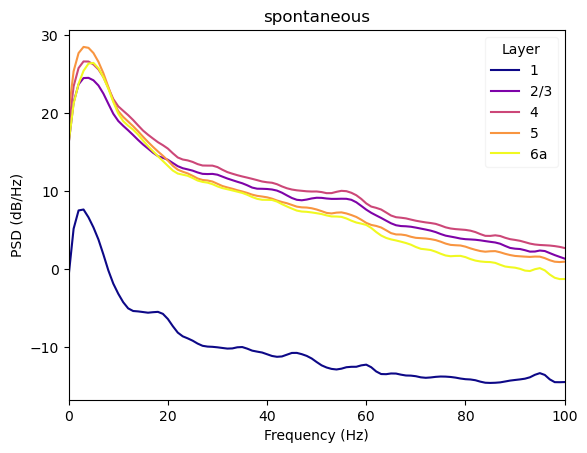

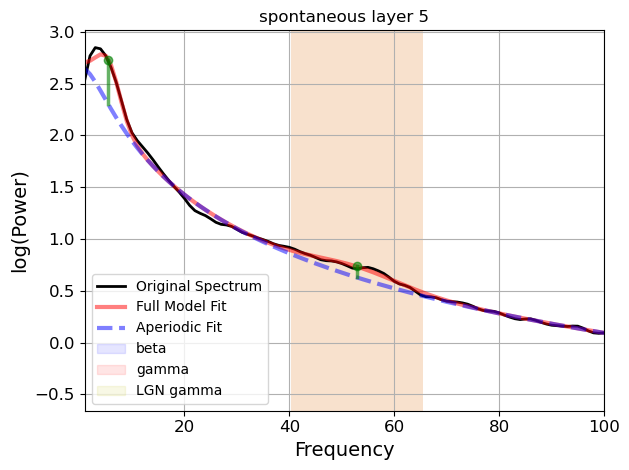

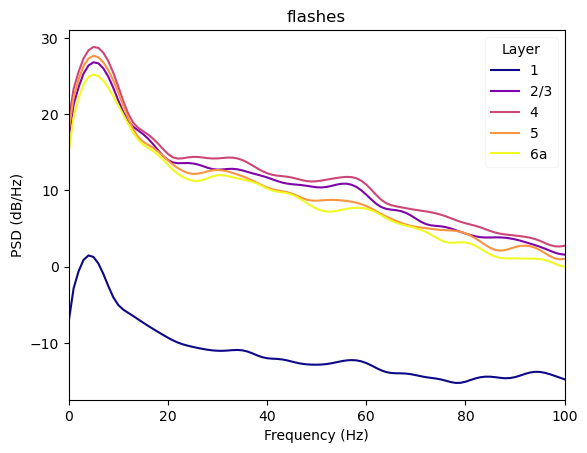

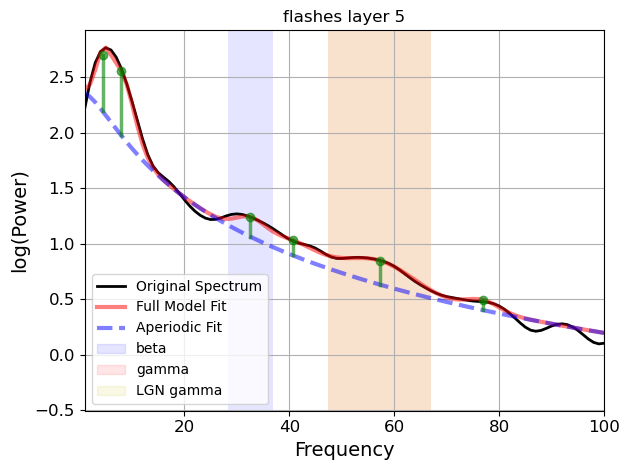

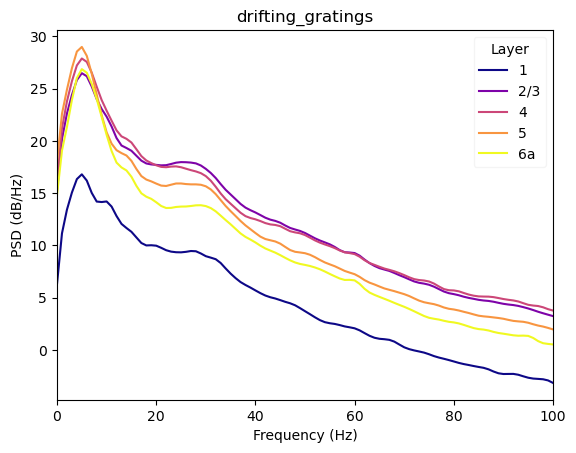

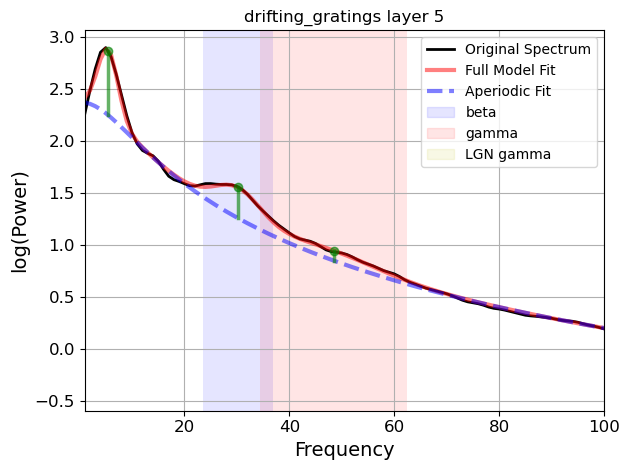

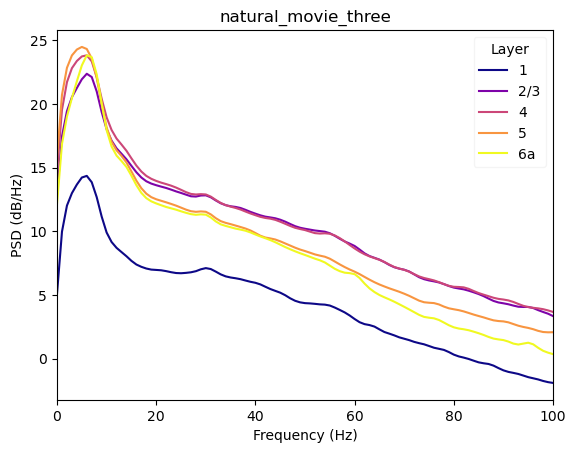

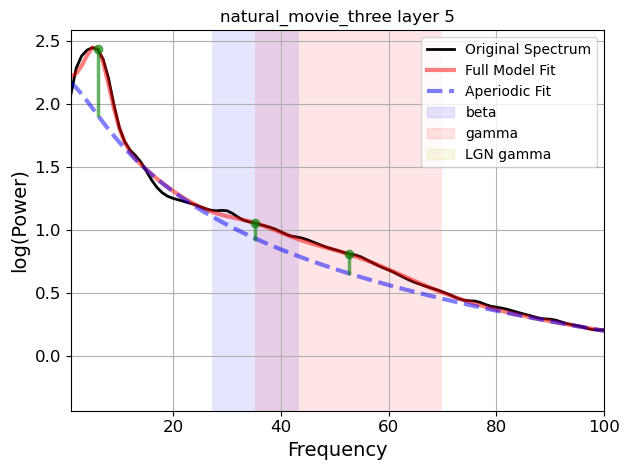

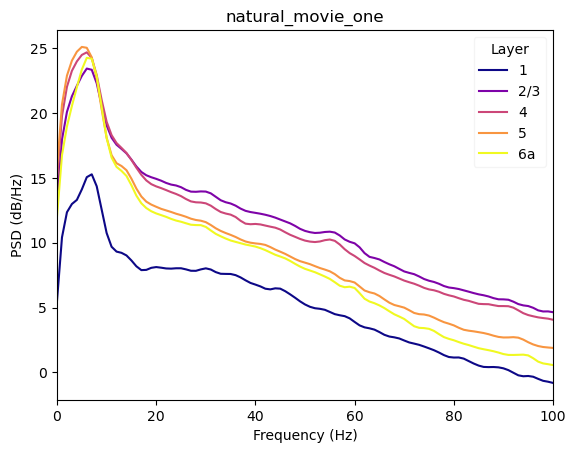

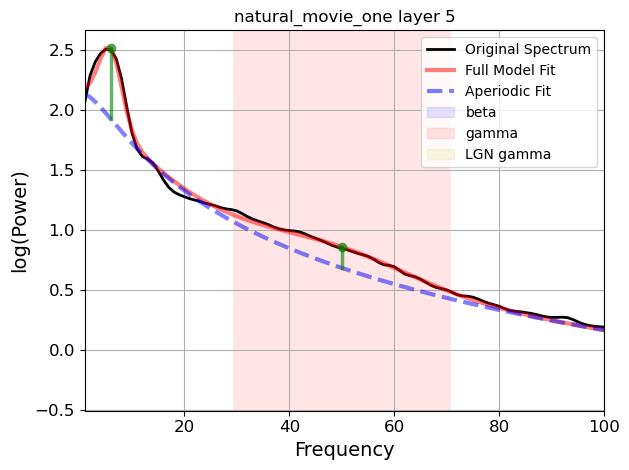

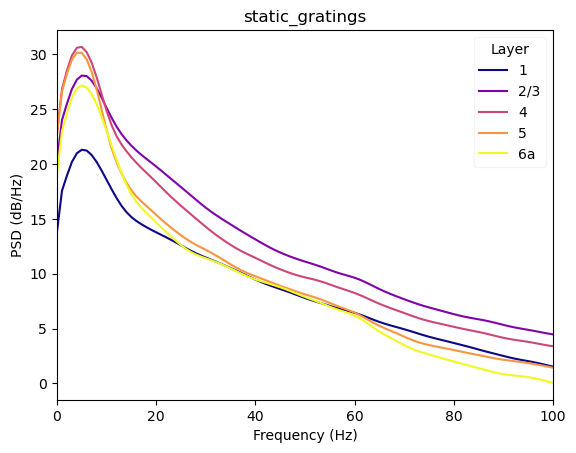

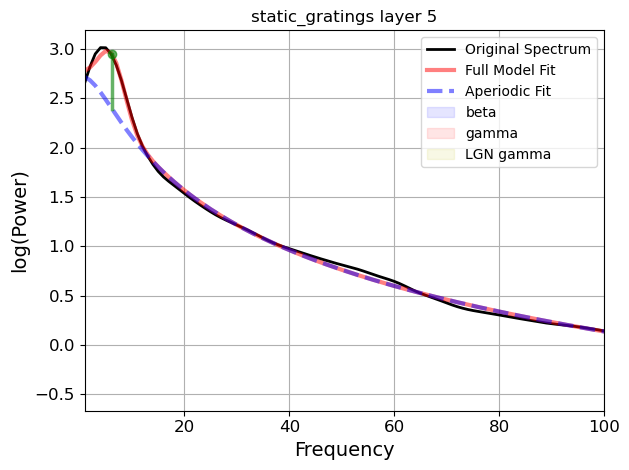

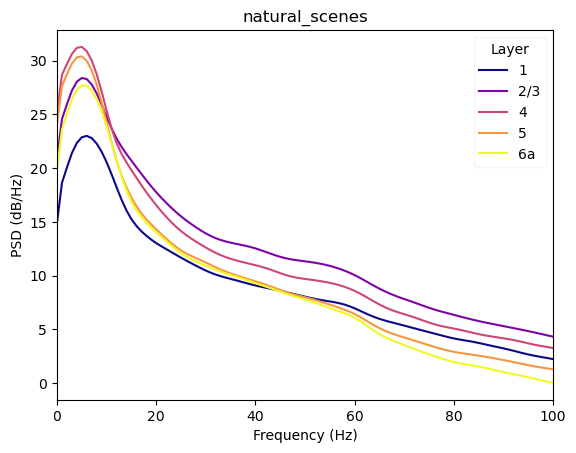

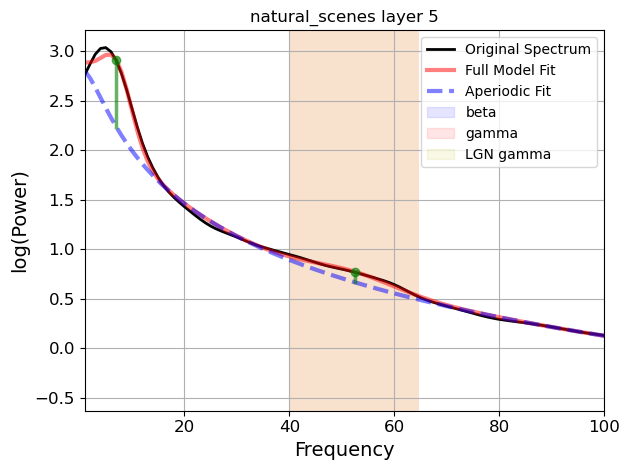

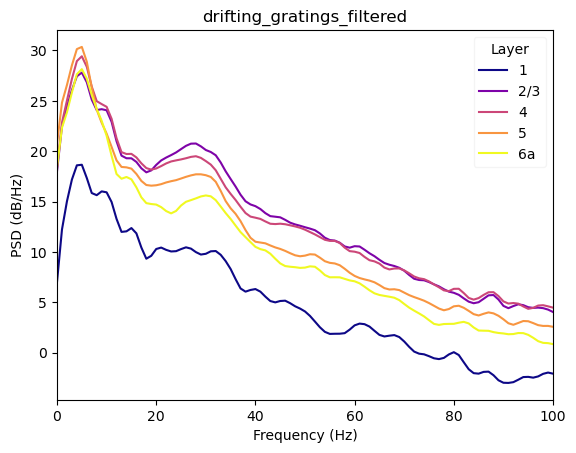

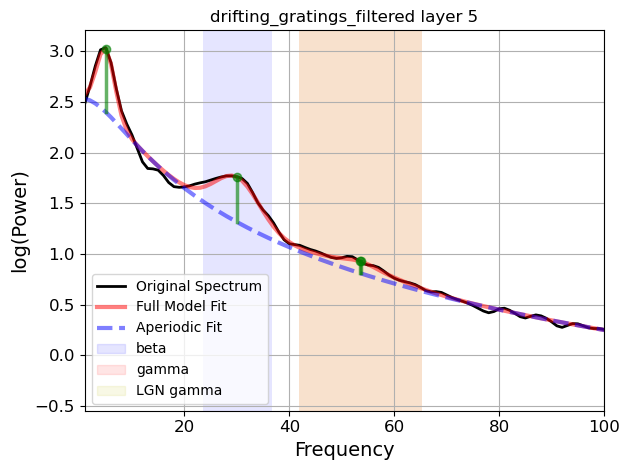

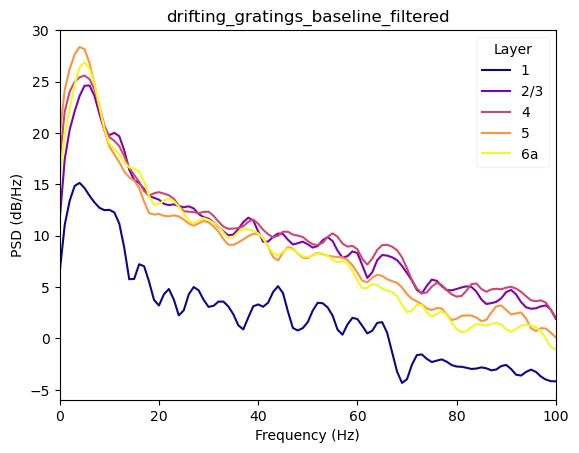

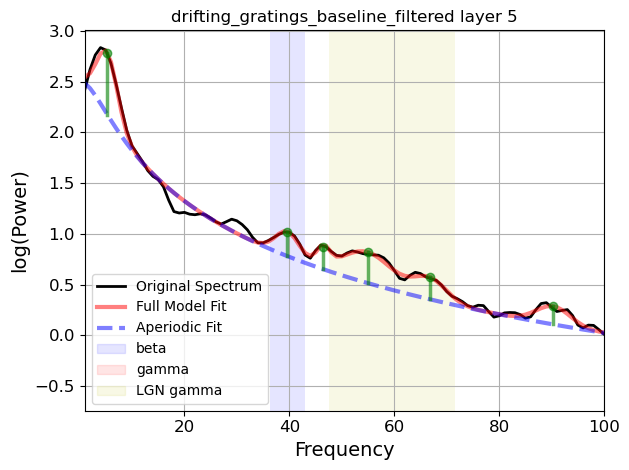

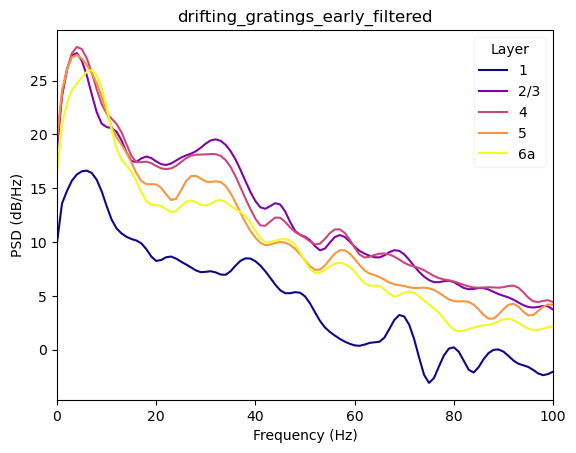

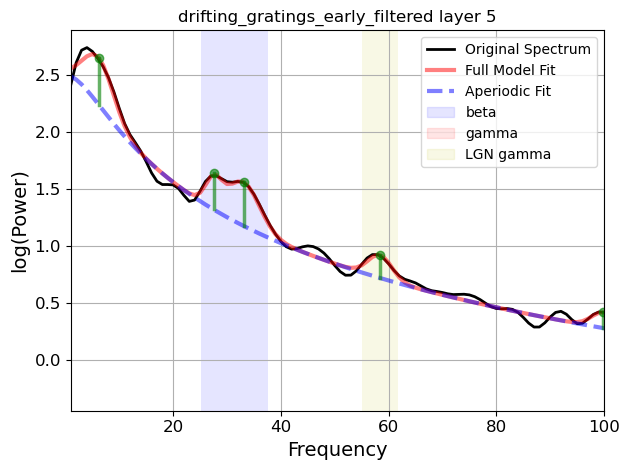

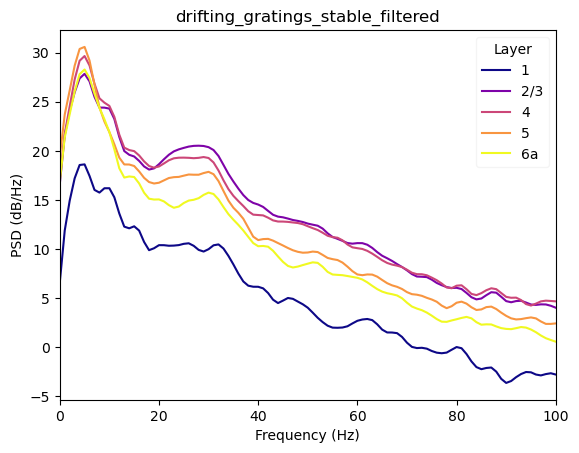

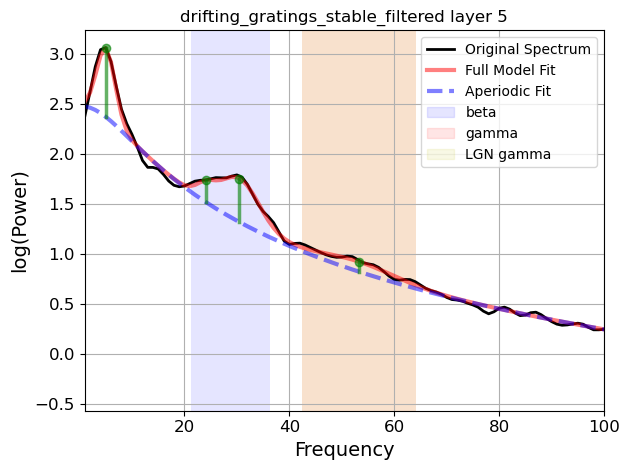

In [16]:
plt_layer = '5'

if plt_layer not in bands_ds.coords['layer']:
    raise ValueError(f"Layer {plt_layer} not found in LFP channels")

for stim, psd_avg in psd_ds.data_vars.items():
    ax = plots.plot_channel_psd(psd_avg, channel_dim='layer', freq_range=plt_range)
    ax.set_title(stim)

    _, ax = plt.subplots(1, 1)
    ax = plots.plot_fooof_quick(fooof_objs[stim][plt_layer], freq_range=plt_range, ax=ax)

    band = bands_ds.bands.sel(stimulus=stim, layer=plt_layer)
    ax = plots.plot_freq_band(band, band.wave_band, ax=ax)
    ax.set_title(f"{stim} layer {plt_layer}")

    plt.show()

drifting_gratings


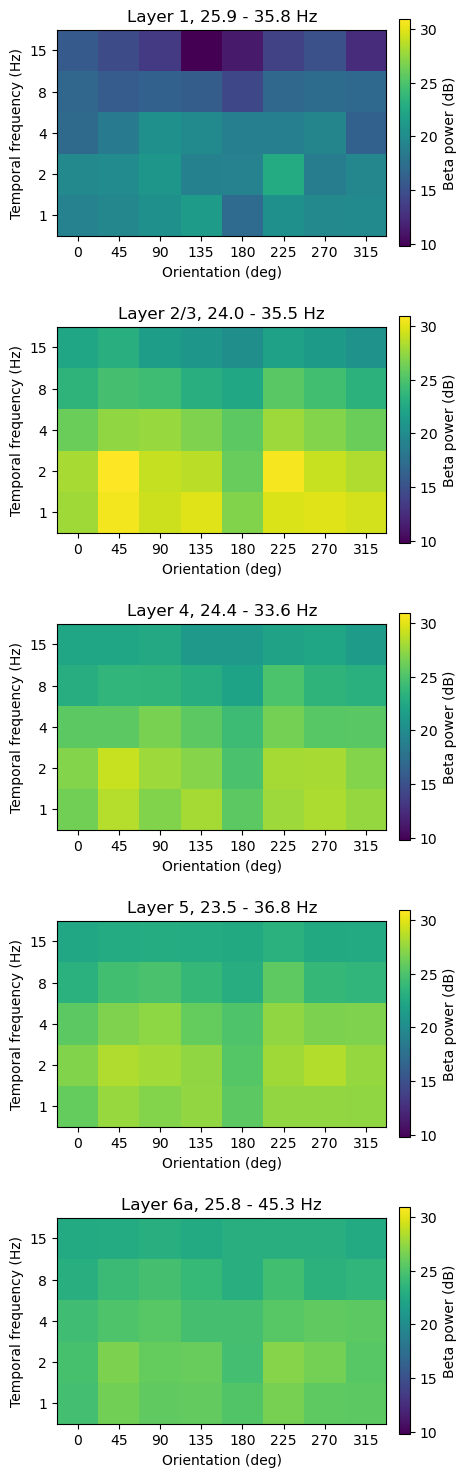

In [17]:
x_cond, y_cond = st.VARIED_CONDITION_TYPES[session_type]

for stim, cond_band_power in cond_band_power_das.items():
    print(stim)
    fig, axs = plots.plot_layer_condition_band_power(cond_band_power, layer_bands_ds[stim], x_cond, y_cond)
    plt.show()